Monte-carlo simulations
====================

In [9]:
from spectrocrunch.simulation.xrmc import XrmcWorldBuilder, loadxrmcresult, showxrmcresult
from spectrocrunch.io import localfs
import numpy as np

Define source

In [10]:
def definesource(world, fullfield=False):
    if fullfield:
        beamsize = 100  # micron
    else:
        beamsize = 1  # micron
    world.definesource(flux=1e9, energy=7.5, distance=42e2, beamsize=beamsize*1e-4)

Define sample based on projected beam size

In [11]:
def definesample(world, fullfield=False):
    projbeamsizesample = 2 * (world.source.distance) * np.tan(world.source.divergence)
    assert world.source.beamsize == projbeamsizesample

    world.removesample()
    thickness = [100e-4, 50e-4]
    materials = ['hematite', 'vacuum']
    if fullfield:
        # Make sure the entire sample is in the beam footprint
        d = projbeamsizesample/2.
    else:
        # Make sure the sample is larger than the beam footprint
        d = projbeamsizesample*10
    dxs = [d/2, d]
    dys = [d/4, d]
    oxs = [-(d-dxs[1])/2., 0]
    oys = [-(d-dys[1])/2., 0]
    oxs[0] = oys[0] = 0
    for t, material, dx, dy, ox, oy in zip(thickness, materials, dxs, dys, oxs, oys):
        world.addcompoundfromname(material)
        world.addlayer(thickness=t, dx=dx, dy=dy, ox=ox, oy=oy, material=material)

XRF detector

In [12]:
def addsdd(world, angle_start=110, angle_end=110, convoluted=False, multiplicity = 2000):
    forcedetect = True
    poissonnoise = False
    distance = 5
    activearea = 0.8  # cm^2
    ebinsize = 5e-3  # keV
    if convoluted:
        world.addelement('Si')
        world.addelement('Be')
        response = {'material': 'Si',
                    'thickness': 100e-4,
                    'windowmaterial': 'Be',
                    'windowthickness': 25e-4,
                    'noise': 0.1,
                    'fano': 0.1}
    else:
        response = {}
    detector = world.addxrfdetector(
                    distance=distance, activearea=activearea,
                    orientation_inplane=angle_start, orientation_outplane=0,
                    ebinsize=ebinsize, poissonnoise=poissonnoise,
                    forcedetect=forcedetect, multiplicity=multiplicity,
                    response=response)
    if angle_start != angle_end:
        angle_nsteps = angle_end-angle_start
        detector.add_inplane_rotationloop(1, angle_nsteps)

Diode in transmission

In [13]:
def adddiode(world, experiment, multiplicity=2000):
    forcedetect = True
    poissonnoise = False
    distance = 5
    world.adddiode(distance=distance, activearea=activearea,
                   orientation_inplane=0, orientation_outplane=0,
                   poissonnoise=poissonnoise, 
                   forcedetect=forcedetect, multiplicity=multiplicity)

Area detector in transmission to view the sample

In [14]:
def addpco(world, multiplicity=1):
    forcedetect = True
    poissonnoise = False
    distance = 5
    shift = 0.001  # cm
    angle = np.arctan2(shift, distance)*180/np.pi  # deg
    ebinsize = 5e-3
    n = 128
    projbeamsizetrans = 2 * (world.source.distance + distance) * np.tan(world.source.divergence)
    pixelsize = projbeamsizetrans/n
    world.addareadetector(distance=distance,
                          pixelsize=(pixelsize, pixelsize), dims=(n, n),
                          orientation_inplane=-angle, orientation_outplane=angle,
                          ebinsize=ebinsize, poissonnoise=poissonnoise,
                          forcedetect=forcedetect, multiplicity=multiplicity)

Function to run the experiment

In [15]:
def run(world, interactions, simulate=True):
    path = localfs.Path(world.main.path)
    if simulate:
        path.remove(recursive=True)
        world.finalize(interactions=interactions)
        if not world.simulate():
            path.ls(recursive=True)
            raise RuntimeError('Simulation failed')
    else:
        world.finalize(interactions=interactions)
    path.ls(recursive=True)
    data, info = loadxrmcresult(world.detector.outpath, world.detector.name)
    #info.pop('xenergy') # in case you want channels
    showxrmcresult(data, ylog=True, **info)

Fullfield
----------

+-/data/id21/tmp/xrmctest/fullfield
  |
  +-compoundlib.dat
  |
  +-dcmspectrum.dat
  |
  +-detector.dat
  |
  +-main.dat
  |
  +-objectlib.dat
  |
  +-output
  | |
  | +-detector.dat
  |
  +-quadrics.dat
  |
  +-sample.dat
  |
  +-synchrotron.dat
Data shape: (2, 1, 128, 128, 1500)
Total counts/order: [896156081.9528055, 0.0]


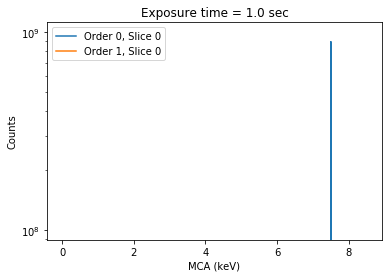

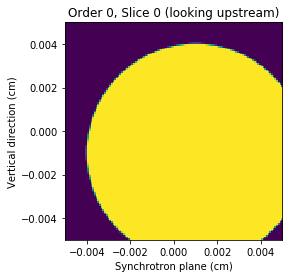

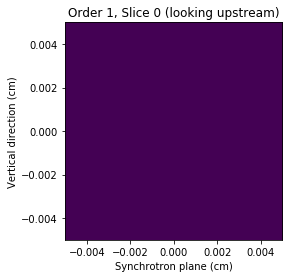

In [16]:
path = r'/data/id21/tmp/xrmctest/fullfield'
world = XrmcWorldBuilder(path)
definesource(world, fullfield=True)
definesample(world, fullfield=True)
addpco(world, multiplicity=1)
run(world, (500, 500), simulate=True)